#### Data Extraction
extract essential information from JSON for the analysis
"title","views", "likes","comments", 'duration','tag','description', 'channel', 'category', 'published'

In [43]:
#extracting json to df
import os, json
import pandas as pd
import numpy as np
import glob
from datetime import datetime
pd.set_option('display.max_columns', None)

dir = 'data'
path = os.path.join(dir, '**/*.json')
file_list = glob.glob(path)
print('Total number of channels ' + str(len(file_list)))
# print(file_list)
dfs = list()

for file in file_list:
    with open(file, 'r') as f:
        data = json.load(f)
    channel_id, stats = data.popitem()
    pchannel_stats = stats["channel_statistics"]
    video_stats = stats["video_data"]
    # sorted_vids = sorted(video_stats.items(), key=lambda item: int(item[1]["viewCount"]),reverse=True)
    vids = video_stats.items()
    stats = []
    for vid in vids:
        video_id = vid[0]
        title = vid[1]["title"]
        try:
            views = vid[1]["viewCount"]
            likes = vid[1]["likeCount"]
            duration = vid[1]['duration']
            tags = vid[1]['tags']
            description = vid[1]['description']
            comments = vid[1]["commentCount"]
            channel = vid[1]['channelTitle']
            published = vid[1]['publishedAt'].split('T')[0]
        except:
            pass
        cat = os.path.dirname(file).split('\\')[1]
        stats.append([title,views, published, likes, comments, duration, tags, description, channel, cat])
    vid_df = pd.DataFrame(stats, columns=["title","views", 'published',"likes","comments", 'duration','tag','description', 'channel', 'category'])
    dfs.append(vid_df)
df = pd.concat(dfs, ignore_index=True)
print('Total number of videos ' + str(df.shape[0]))


Total number of channels 112
Total number of videos 43209


Data Cleaning

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43209 entries, 0 to 43208
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        43209 non-null  object
 1   views        43209 non-null  object
 2   published    43209 non-null  object
 3   likes        43209 non-null  object
 4   comments     43209 non-null  object
 5   duration     43209 non-null  object
 6   tag          43209 non-null  object
 7   description  43209 non-null  object
 8   channel      43209 non-null  object
 9   category     43209 non-null  object
dtypes: object(10)
memory usage: 3.3+ MB


In [45]:
# convert published date into datetime
df.published = pd.to_datetime(df.published, format='%Y-%m-%d')

# convert duration into minute with regex

df.sample(5)

,title,views,published,likes,comments,duration,tag,description,channel,category
39177,"Lake Como, Italy: Bellagio and Varenna",525512,2012-05-10,2135,77,PT3M1S,"[Rick Steves, Milano, rick steves lake como, l...",More info about travel to the Italian Lakes: h...,Rick Steves' Europe,Travel
26787,By the Numbers: Thousands of students ‘missing...,6538,2021-06-12,100,31,PT1M35S,"[abcnl, by, from, many, missing, numbers, of, ...",A look at the thousands of students who fell o...,ABC News,News
4728,Cool Guys Don't Look At Explosions,50205179,2009-06-05,363087,39897,PT2M31S,"[Andy, Samberg, 2009, MTV, Movie, Awards, SNL,...",Here's the song we made for the 2009 MTV Movie...,thelonelyisland,Comedy
28058,Sean Penn helps Ukrainian fighter pilots lobby...,68014,2022-06-25,2166,1620,PT3M24S,"[latest News, Happening Now, CNN, Moonfish, Ju...",CNN's Jim Acosta speaks to actor Sean Penn and...,CNN,News
15316,What's the Difference Between Baking Powder an...,1868105,2016-11-14,34250,954,PT5M8S,"[SciShow, science, Hank, Green, education, lea...",Powder vs. Soda: an important distinction!\n\n...,SciShow,Educational


convert text into Word2Vec

In [46]:
import pandas as pd
import gensim.downloader as api
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
# import nltk; nltk.download('popular')

We use gensim pretrained model called 'glove-wiki-gigaword-50' with the model trained on wikipedia dataset

In [47]:
# importing pretrained gensim model to convert text tokens into vector
model_wv = api.load('glove-wiki-gigaword-50')

In [48]:
# function to convert token to word vector with word2vec finding average vector for the document
# tokenize function with df series as input to give a list of list result of each title
def df_token(df_text_series):
    # set of english stopwords
    stopset = set(stopwords.words('english'))
    token_item = []
    for t in df_text_series:
        if type(t) == list:
            t = ' '.join(t)
        else:
            pass
        tokens = [word for word in word_tokenize(t.lower()) if word not in stopset]
        token_item.append(tokens)
    return token_item

def gen_word_vec(df_text_series, wordvec):
    word_vector = []
    for token in df_token(df_text_series):
        token_considered = [t for t in token if t.isalpha]
        token_vocab = [i for i in token_considered if i in wordvec.key_to_index]
        if len(token_vocab) > 0:
            word_vector.append(np.mean(wordvec[token_vocab], axis=0))
        else:
            word_vector.append(np.zeros(wordvec.vector_size))
    word_vector = np.array(word_vector)
    return word_vector

In [49]:
title_word_vec = gen_word_vec(df.title, model_wv)
tag_word_vec = gen_word_vec(df.tag, model_wv)
desc_word_vec = gen_word_vec(df.description, model_wv)

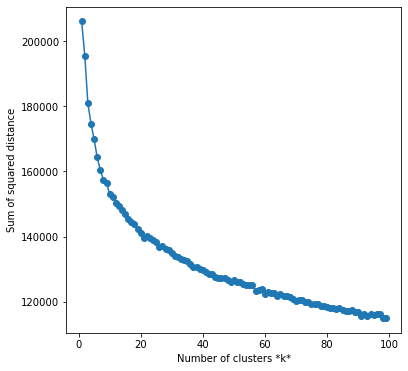

In [59]:
# Let's explore the clustering of word embadding vector using K-Means
# first let's find optimal number of cluster using elbow methods
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
# # stardize the data in case the data are not normalized
# df_clustering = df.copy()
# X = StandardScaler().fit_transform(df_clustering.iloc[:, 1:])

# workingin title word embedding
sse=[] # sum of square error
list_k = list(range(1, 100))

for k in list_k:
    km = MiniBatchKMeans(n_clusters=k, init='k-means++', max_iter=300, random_state=0, batch_size=2048)
    km.fit(title_word_vec)
    sse.append(km.inertia_)

plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

From the title word embedding we see no clear clustering based on the elbow method, we will try to see if the tag will produce similar results

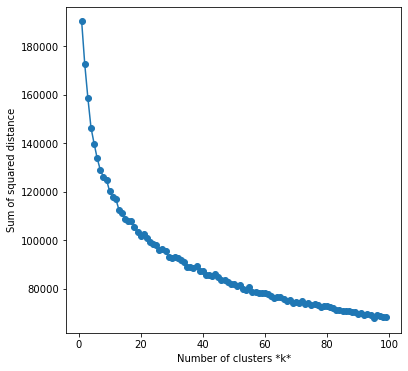

In [58]:
sse=[] # sum of square error
list_k = list(range(1, 100))

for k in list_k:
    km = MiniBatchKMeans(n_clusters=k, init='k-means++', max_iter=300, random_state=0, batch_size=2048)
    km.fit(tag_word_vec)
    sse.append(km.inertia_)

plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

We still see similar shape of sum of square error for different number of cluster on tag word embedding. Let's explore silhouette plot to examine different number of cluster.

c:\Users\poomk\miniconda3\envs\dataenv\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
c:\Users\poomk\miniconda3\envs\dataenv\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
c:\Users\poomk\miniconda3\envs\dataenv\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable 

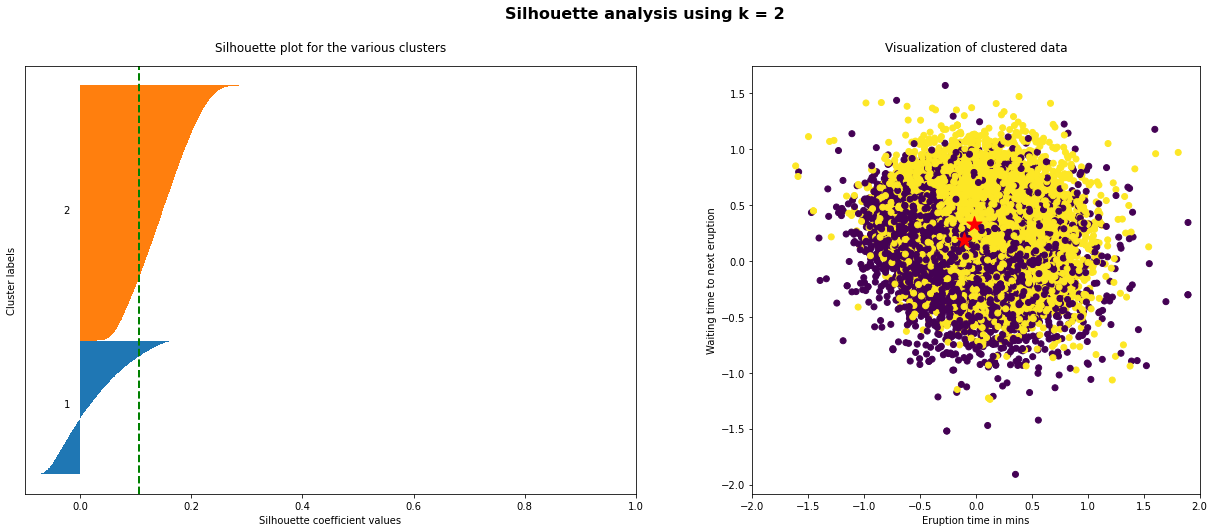

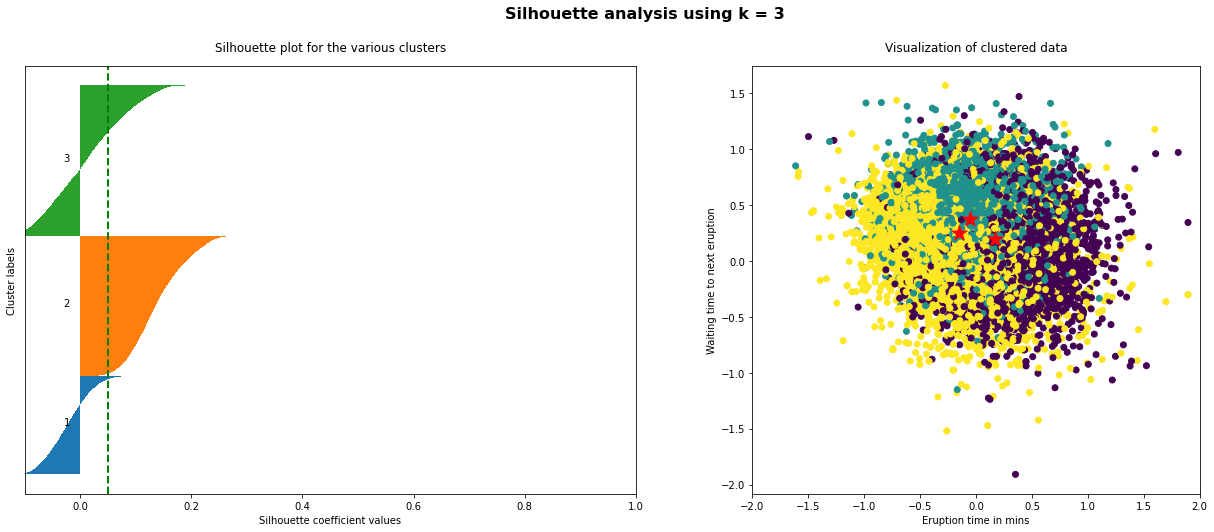

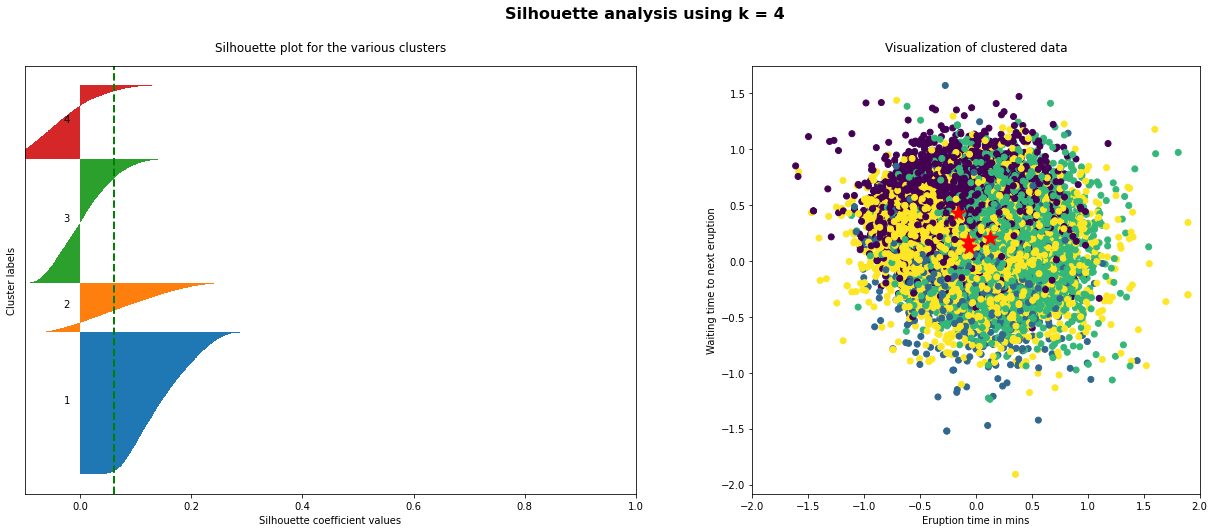

In [61]:
# use silhouette plot code from sklearn documentation page https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
#set the dataset to be working with
X = title_word_vec

for i, k in enumerate([2, 3, 4]):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    km = MiniBatchKMeans(n_clusters=k, batch_size=2048)
    labels = km.fit_predict(X)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(X, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);
    
    # Scatter plot of data colored with labels
    ax2.scatter(X[:, 0], X[:, 1], c=labels)
    ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
    ax2.set_xlim([-2, 2])
    ax2.set_xlim([-2, 2])
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_title('Visualization of clustered data', y=1.02)
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);